In [105]:
import torch
import numpy as np
import matplotlib.pyplot as plt

Создадим набор данных, порожденный некоторой линейной функцией $y = k x + b$. Для модели регрессии эта функция будет неизвестна, ее "угадывание" или восстановление как раз и будет происходить в ходе обучения регрессионной модели. 

In [106]:
def true_fun(x):
    return 0.5 * x + 0.17

# Параметр, контролирующий шум, добавляемый к сгенерированным данным
# (чтобы они отклонялись от уравнения, заданного в `true_fun`)
NOISE_SIGMA = 0

In [107]:
x = np.random.random(6)
y = true_fun(x) + np.random.normal(0, NOISE_SIGMA, x.shape)

Вспомогательная функция для визуализации набора (и модели):

In [108]:
def plot(x, y, foo=None):
    plt.scatter(x, y)
    if foo is not None:
        x_ = np.arange(0, 1.0, 0.05)
        y_ = foo(torch.from_numpy(x_)).numpy(force=True)
        plt.plot(x_, y_, color='orange')
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.0])

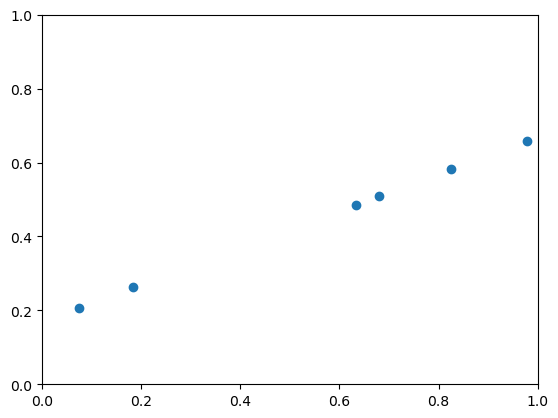

In [109]:
plot(x, y)

Определим класс `LinearModel`, инкапсулирующий в себе линейную модель одной переменной: $h(x) = \hat{k}x + \hat{b}$. Нотация $\hat{\cdot}$ часто используется для того, чтобы подчеркнуть, что соответствующие параметры являются оценками некоторых реальных, но неизвестных параметров. В нашем случае так и есть: $\hat{k}$ - это оценка параметра $k$, а $\hat{b}$ - оценка параметра $b$.

Экземпляр класса `LinearModel` содержит два тензора-скаляра, соответствующих параметрам модели. Важно, что эти тензоры сконструированы указанием `requires_grad=True`. Это означает, что действия над ними будут "записываться" и по результатам этих действий для этих параметров может быть вычислен градиент.  

In [110]:
class LinearModel:
   
    def __init__(self):
        # Параметры модели
        self.k = torch.tensor(0.0, requires_grad=True)
        self.b = torch.tensor(0.0, requires_grad=True)        

    def __call__(self, x):
        """Вычисление значения модели для заданного аргумента."""
        return self.k * x + self.b

    def parameters(self):
        """Список параметров модели."""
        return [self.k, self.b]

    def __str__(self):
        """Строковое представление."""
        return f'LinearModel: k={self.k:.4f} b={self.b:.4f}'
    
class GDOptimizer:
    
    def __init__(self, parameters, alpha=0.1):
        self.parameters = parameters
        self.alpha = alpha
    
    def step(self):
        """Шаг оптимизации.
        
        Каждый из оптимизируемых параметров следует изменить в направлении,
        противоположном градиенту (на величину, пропорциональную величине
        градиента).
        """
        for parameter in self.parameters:
            parameter.data = parameter.data - parameter.grad.data * self.alpha
    
    def zero_grad(self):
        """Сброс градиента для всех оптимизируемых параметров."""
        for parameter in self.parameters:
            if parameter.grad is not None:
                parameter.grad.zero_()
        

In [111]:
# Создадим экземпляр модели
model = LinearModel()
# Создадим экземпляр оптимизатора, связав его с
# параметрами оцениваемой линейной модели
optimizer = GDOptimizer(model.parameters())

# Исходные данные для обучения следует преобразовать
# в тензоры, во-первых, потому что внутри `LinearModel`
# над ними будут проводиться операции (умножение на тензор и сложение с ним),
# а операции между numpy-массивом и тензором невозможны,
# во-вторых, потому что эти данные будут использоваться в 
# ходе вычисления функции потерь (лосс-функции) для которой
# должно применяться автоматическое дифференцирование.
# При этом `torch.from_numpy()` бережно относится к памяти - 
# без необходимости новую не выделяет.
x_tensor = torch.from_numpy(x)
y_tensor = torch.from_numpy(y)

In [112]:
i = 0
while True:
    # Сбросим градиент (чтобы результаты предыдущей
    # итерации не влияли на направление изменения параметров)
    optimizer.zero_grad()
    # Вычислим ошибку предсказаний модели
    loss = torch.sum((model(x_tensor) - y_tensor) ** 2)
    print(loss.item())
    # Вычислим градиент ошибки предсказаний модели по всем
    # параметрам
    loss.backward()
    # Скорректируем значения параметров
    optimizer.step()
    i += 1
    if i % 10 == 0:
        print(model)
    # Условие останова - если ошибка становится достаточно маленькой
    if loss < 0.001:
        break

1.3814875019592747
0.5419672370014068
0.2229168206382045
0.09973983520081126
0.050630666000882805
0.029817074804191736
0.020046219533263673
0.014772185742707455
0.01147647947983038
0.009161924560816893
LinearModel: k=0.3926 b=0.2321
0.0074112305070174415
0.006032354924023022
0.004924162317189441
0.004024879514784693
0.0032918313065733984
0.002693044082079555
0.002203459296127315
0.0018029840038206052
0.0014753341881685446
0.0012072416134101868
LinearModel: k=0.4612 b=0.1937
0.0009878721143287202


In [95]:
print(model)

LinearModel: k=0.3433 b=0.2594


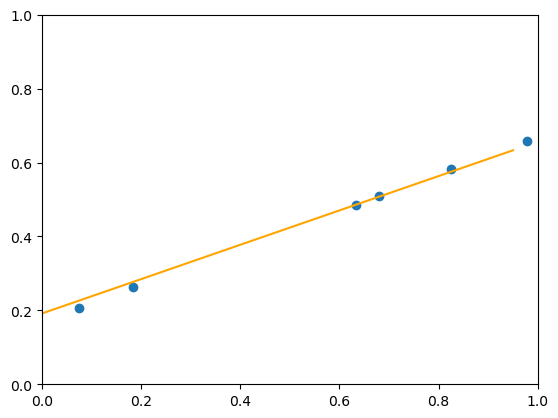

In [113]:
plot(x, y, model)

In [114]:
for _ in range(10):
    loss = torch.sum((model(x_tensor) - y_tensor) ** 2)
    print(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

0.0008083658976963935
0.0005162321722837012
0.00042242591045604674
0.00034566711091552614
0.0002828565670280871
0.0002314592799067294
0.00018940097857998695
0.0001549853997539364
0.00012682341696916468
0.00010377877927369063


In [115]:
print(model)

LinearModel: k=0.4886 b=0.1770


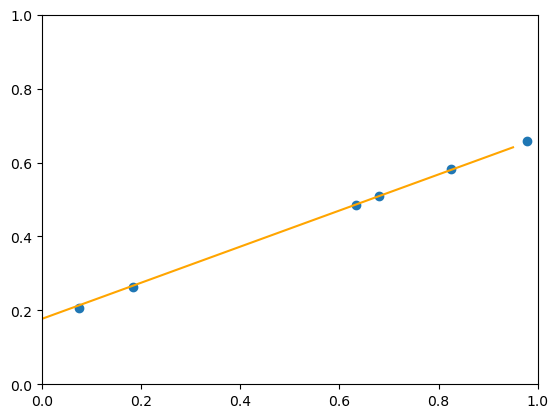

In [116]:
plot(x, y, model)

In [120]:
for _ in range(10):
    loss = torch.sum((model(x_tensor) - y_tensor) ** 2)
    print(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

2.071390568007928e-07
1.695047967070905e-07
1.3869982548079614e-07
1.1349336100195688e-07
9.286560871356296e-08
7.599361616805872e-08
6.217998350939684e-08
5.088149745667162e-08
4.163261121636132e-08
3.406608859328091e-08


In [121]:
print(model)

LinearModel: k=0.4998 b=0.1701


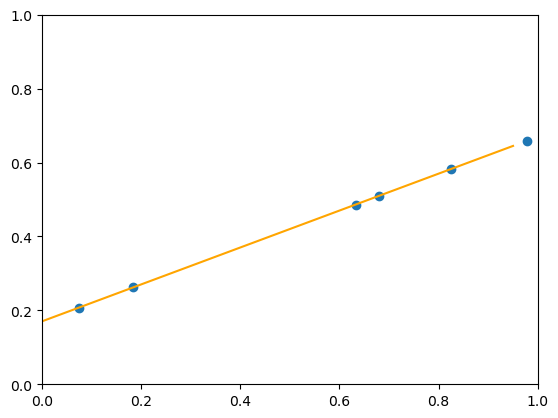

In [122]:
plot(x, y, model)